In [1]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.optimize
import sklearn.decomposition
import sklearn.manifold
import sklearn.model_selection

Your task is to use and evaluate dimension reduction techniques (PCA and t-SNE) on the California housing dataset. The assignment is at the end of this notebook, in Section 2. First, here is some code
that illustrates PCA and t-SNE.

# 1 Demo code
## 1.1 Import and plot a dataset

We'll use the same dataset as in lecture 1, the World Bank dataset of statistics about states.

In [35]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/lecture1-introduction/data/country-stats.csv'
countries = pandas.read_csv(url)
countries.iloc[:3]

,Country Name,GDP per Capita (PPP USD),Population Density (persons per sq km),Population Growth Rate (%),Urban Population (%),Life Expectancy at Birth (avg years),Fertility Rate (births per woman),Infant Mortality (deaths per 1000 births),"Enrolment Rate, Tertiary (%)","Unemployment, Total (%)",Estimated Control of Corruption (scale -2.5 to 2.5),Estimated Government Effectiveness (scale -2.5 to 2.5),Internet Users (%)
0,Afghanistan,1560.67,44.62,2.44,23.86,60.07,5.39,71.0,3.33,8.5,-1.41,-1.40,5.45
1,Albania,9403.43,115.11,0.26,54.45,77.16,1.75,15.0,54.85,14.2,-0.72,-0.28,54.66
2,Algeria,8515.35,15.86,1.89,73.71,70.75,2.83,25.6,31.46,10.0,-0.54,-0.55,15.23


In [36]:
print(countries['Country Name'])

0              Afghanistan
1                  Albania
2                  Algeria
3      Antigua and Barbuda
4                Argentina
              ...         
156                Vanuatu
157              Venezuela
158                Vietnam
159                  Yemen
160                 Zambia
Name: Country Name, Length: 161, dtype: object


Plot a splom. There's lots of messy matplotlib code to make plots look nice, and it calls for frequent use of stackoverflow.

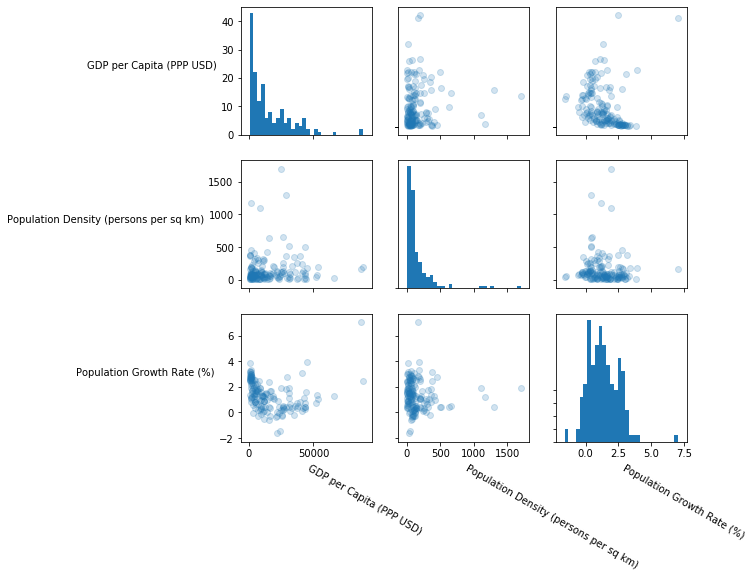

In [37]:
# Pick out the first three columns, excluding "Country Name", to show in the splom
features = countries.columns[1:4]

with plt.rc_context({'figure.figsize': (8,8)}):
    fig,ax = plt.subplots(len(features), len(features), sharex='col', sharey='row')

# We'll plot histograms on the diagonal, so they shouldn't share y-axis with the scatter plots
for i in range(len(features)):
    ax[i,i].get_shared_y_axes().remove(ax[i,i])

# Plot histograms or scatter plots as appropriate
for i,c in enumerate(features):
    for j,d in enumerate(features):
        if i == j:
            ax[i,j].hist(countries[d], bins=30)
        else:
            ax[i,j].scatter(countries[d], countries[c], alpha=.2)

# Rotate tick labels to make them legible
for i,c in enumerate(features):
    ax[i,0].set_ylabel(c, rotation=0, horizontalalignment='right')
for j,d in enumerate(features):
    ax[len(features)-1,j].set_xlabel(d, rotation=-30, ha='left')

plt.show()

## 1.2 One-dimensional PCA

Here is an entirely manual version of one-dimensional PCA. You never need to code PCA yourself, since there are much more efficient libraries to do it for you, but it's useful to see how little there is to it. If you want to build fancier algorithms for dimension reduction, such as autoencoders, you'll have to code similar steps to these, perhaps implementing them in TensorFlow.

Optimization terminated successfully.
         Current function value: 225.098938
         Iterations: 44
         Function evaluations: 85


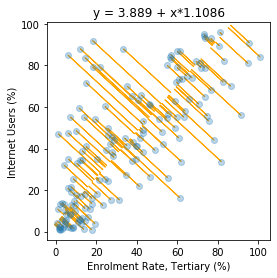

In [38]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'

# We'll look for a straight line fit   y = m*x + c.
# This isn't the best parameterization (it can't represent a vertical line), but it's simple
# and sufficient for this problem.

def proj(x, y, θ):
    # Given vectors x and y, project them onto the line θ=(m,c)
    m,c = θ
    
    # Initial y0 coordinate, when dx=1 dy=m
    y0,dx,dy = c,1,m
    
    # Normalise
    d = np.sqrt(dx**2 + dy**2)
    dx,dy = dx/d, dy/d
    
    # Dot product (projection) of the actual coordinate of interest (x,y)
    dot = x*dx + (y-y0)*dy
    return dot*dx, y0 + dot*dy

def err(θ):
    # Given straight-line parameters θ=(m,c), find the mean square error of all the projections
    px,py = proj(countries[fx], countries[fy], θ)
    ex,ey = countries[fx]-px, countries[fy]-py
    return np.mean(ex**2 + ey**2)

# Run an optimizer to find the error-minimizing parameters.
# Here I'm using the built in scipy.optimize.fmin.
# You could also implement this with gradient descent.

m,c = scipy.optimize.fmin(err, x0=[.9,10])

# Project the data onto the fitted straight line
predx,predy = proj(countries[fx], countries[fy], (m,c))

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(countries[fx], countries[fy], alpha=.3)
for x,y,px,py in zip(countries[fx], countries[fy], predx, predy):
    ax.arrow(x,y, px-x,py-y, color='orange', zorder=-1)
ax.set_xlabel(fx)
ax.set_ylabel(fy)
plt.title(f"y = {c:.5} + x*{m:.5}")
plt.show()

Here's the same model, fitted using the PCA library function.

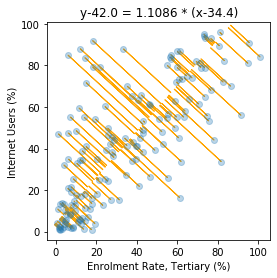

In [39]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'
X = countries[[fx,fy]].values

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# Find the predictions from the PCA model, using just the first component
μx,μy = pca.mean_
δx,δy = pca.components_[0]
λ = pca_result[:,0]
predx,predy = μx+λ*δx, μy+λ*δy

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(X[:,0], X[:,1], alpha=.3)
for x,y,px,py in zip(X[:,0], X[:,1], predx, predy):
    ax.arrow(x,y, (px-x),py-y, color='orange', zorder=-1)
ax.set_xlabel(fx)
ax.set_ylabel(fy)
plt.title(f"y-{μy:.3} = {δy/δx:.5} * (x-{μx:.3})")
plt.show()

## 1.3 Full PCA

Here is the full PCA, run on the entire set of features. 

PCA looks for a good approximation to your dataset, and it treats an error of size $e$ in one feature as just as serious as an error of size $e$ in any other feature. It's therefore wise to scale the features appropriately. If you don't have any real insight into how you should weight them, then just make all your columns have the same variance.

The standard library call fits the model
$$
\vec{x}_i = \vec{\mu} + \sum_{k=1}^K \lambda_{k,i} \vec{\delta}_k
$$
where $K$ is the total number of features in the dataset, and $\vec{x}_i$, $\vec{\mu}$, $\vec{\delta}_k$ are all $K$-dimensional vectors. The basis vectors it returns, $\vec{\delta}_1,\dots,\vec{\delta}_K$, are orthonormal.

PCA puts the components $\vec{\delta}_k$ so that the most important comes first, i.e. so that if you want to approximate the data using only $L<K$ components then you should use the first $L$,
$$
\vec{x}_i = \vec{\mu} + \sum_{k=1}^L \lambda_{k,i} \vec{\delta}_k + \vec{\varepsilon}_i
$$
where the error term $\vec{\varepsilon}_i$ the sum of terms from components $\{L+1,\dots,K\}$. Since the basis vectors
are orthogonal, $\vec{\varepsilon}_i$ is orthogonal to $\{\vec{\delta}_1,\dots,\vec{\delta}_L\}$.

In [40]:
# drop the column 'Country Name', which isn't numeric
features = countries.columns[1:]
X = countries[features].values

# rescale the features, so they have the same variance
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# how the results are returned
print("μ:", pca.mean_)
k,i = 2,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [9.54780563e-01 6.59481318e-01 1.16550076e+00 2.43443295e+00
 8.06247583e+00 1.98804330e+00 1.05052397e+00 1.28125213e+00
 1.22381235e+00 7.32740877e-03 5.19484572e-02 1.45502392e+00]
δ[k=2]: [-0.21521157  0.81173439 -0.18916308 -0.21801048  0.13379205 -0.19250245
 -0.13653149 -0.08295349 -0.30953473 -0.1667017  -0.06814961 -0.05229533]
λ[k=2,i=10]: 4.650211499899456


PCA gives us a nice way to summarize a large number of features in two dimensions.

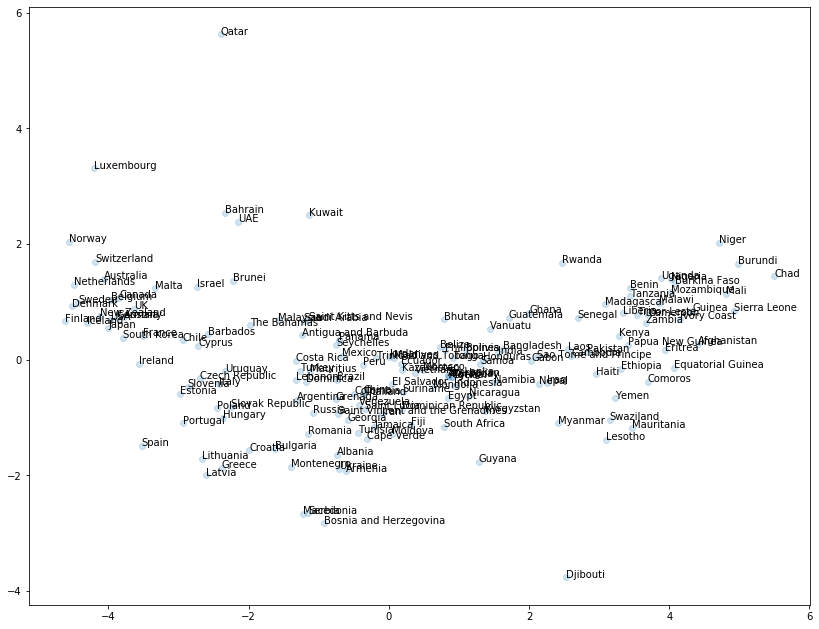

In [41]:
p1,p2 = pca_result[:,0], pca_result[:,1]

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
for x,y,s in zip(p1,p2,countries['Country Name']):
    ax.text(x,y,s)
plt.show()

## 1.4 t-SNE

t-SNE is another tool for dimension reduction. You have to tell it how many components you want it to produce (unlike PCA, which produces all components and then it's up to you how many to use).

In [45]:
# use all the numerical features, and drop the column 'Country Name'
features = countries.columns[1:]

# as with PCA, we should be careful about the scale of data we present to the algorithm
X = countries[features].values
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])
    
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 161 samples in 0.000s...
[t-SNE] Computed neighbors for 161 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 161 / 161
[t-SNE] Mean sigma: 1.399072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.908733
[t-SNE] KL divergence after 1000 iterations: 0.389012


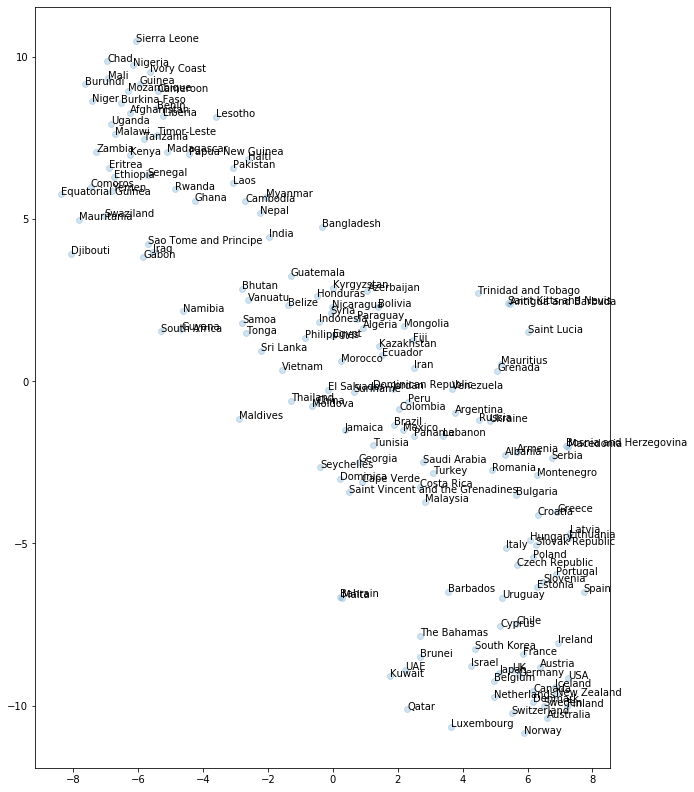

In [49]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,14))
ax.scatter(p1, p2, alpha=.2)
for x,y,s in zip(p1,p2,countries['Country Name']):
    plt.text(x,y,s)
# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')
plt.show()

<div style="height: 15em"></div>

# 2. Assignment

In [50]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/DSPNP_practical1/housing/housing.csv'
housing = pandas.read_csv(url)
features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

In [51]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Question 1.** Use principal components analysis (PCA) on the above list of features. You should scale the columns appropriately. Plot a scatter plot of the first two components, and colour-code the points by `ocean_proximity`.

Note: A quick and dirty way to colour-code a scatter plot in `matplotlib` is with
```
for lvl in distinct levels of some feature z:
    i = (z == lvl)
    plt.scatter(x[i], y[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
```

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('std_scaler', StandardScaler()),
    ])


X = housing.sample(n=2500, random_state=0)

X_prepared = pipeline.fit_transform(X[features])
X_prepared

array([[-0.53180237, -0.22886356, -0.33092868, ..., -0.33414493,
         0.15571849, -0.59968005],
       [ 0.26426129,  0.02600439, -0.33348284, ..., -0.17243618,
         1.00994086,  0.295249  ],
       [ 0.02544219,  0.29462244,  0.04964121, ...,  0.12031243,
         0.25904592, -0.05277897],
       ...,
       [ 0.10504856,  0.91926989,  1.47230853, ...,  1.45022752,
         0.0227415 ,  0.85243663],
       [ 0.66229312, -0.37913252, -0.62210296, ..., -0.64083394,
         1.95442385,  2.51286434],
       [-0.61140873, -0.89770777, -0.67318617, ..., -0.68265517,
        -0.71865508, -0.21907804]])

In [53]:
pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X_prepared)

# how the results are returned
print("μ:", pca.mean_)
k,i = 2,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [ 9.94759830e-17  8.38440428e-17 -1.74793513e-16  2.80664381e-17
  7.81597009e-18  3.22586402e-16  1.13686838e-16]
δ[k=2]: [ 0.94408236  0.01736535  0.11999915  0.09621026  0.14098888 -0.19336461
  0.16577998]
λ[k=2,i=10]: 0.8851902090499975


In [54]:
pca_result.shape

(2500, 7)

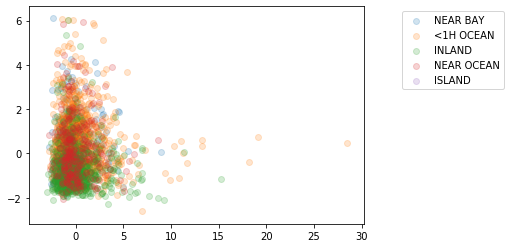

In [55]:
%matplotlib inline

p1,p2 = pca_result[:,0], pca_result[:,1]

for lvl in housing['ocean_proximity'].unique().tolist():
    i = (X['ocean_proximity'] == lvl)
    plt.scatter(p1[i], p2[i], label=lvl, alpha=0.2, cmap='Set2')

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

**Question 2.** Answer question 1 but using t-SNE rather than PCA. Which method seems to produce more helpful clustering?

Note: For speed, you may like to answer questions 1 and 2 working with a subset of several thousand rows, rather than using the full dataset, because t-SNE is slow.

In [56]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(X_prepared)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.002s...
[t-SNE] Computed neighbors for 2500 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.406356
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.656876
[t-SNE] KL divergence after 1000 iterations: 1.222277


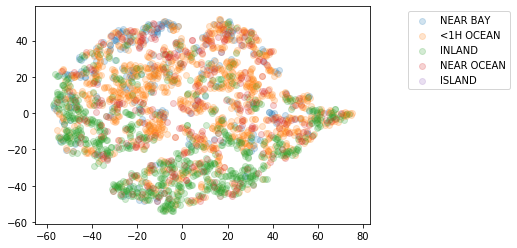

In [57]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]

for lvl in housing['ocean_proximity'].unique().tolist():
    i = (X['ocean_proximity'] == lvl)
    plt.scatter(p1[i], p2[i], label=lvl, alpha=0.2, cmap='Set2')

plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
# plt.figaspect('equal')
plt.show()

In this case, t-SNE seems to be more helpful as it separates the datapoints better with them being easier to distinguish. In PCA most of the points are in the same region of the plot with very high density, so individual points are hard to distinguish.

In addition, some clusters might be seen in the t-SNE decomposition where some sets of datapoints are more separated from the others.

**Question 3.** In the t-SNE plot in Section 1.4 above, why did I use `set_aspect('equal')`? Why didn't I choose to use it for the PCA plot?

**Answer:** Since the relative distances between the points are important in any direction, the relative distances across the dimensions should be preserved when plotting. `set_aspect(equal)` preserves the relative distances across `x` and `y` axes.

PCA on the other hand does preserve relative distances in the original space of the datapoints, so they are not as important when plotting.

**Question 4.** Repeat question 2 but using a range of values of perplexity, in the range \[5,50\]. Do you see different clustering for different values of perplexity?

Note: perplexity is mentioned in the [sklearn.manifold.TSNE reference](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Here's a good read on [how to use t-SNE effectively](https://distill.pub/2016/misread-tsne/).

In [69]:
tsnes = [sklearn.manifold.TSNE(n_components=2, perplexity=5.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=10.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=15.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=25.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=50.0, verbose=1),
         sklearn.manifold.TSNE(n_components=2, perplexity=50.0, verbose=1)]
tsne_results = [tsne.fit_transform(X_prepared) for tsne in tsnes]

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.230522
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.011177
[t-SNE] KL divergence after 1000 iterations: 1.168687
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2500 samples in 0.001s...
[t-SNE] Computed neighbors for 2500 samples in 0.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2500
[t-SNE] Computed conditional probabilities for sample 2000 / 2500
[t-SNE] Computed conditional probabilities for sample 2500 / 2500
[t-SNE] Mean sigma: 0.294810
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.364227
[t-SNE] KL divergence after 1000 iterations: 1.246085


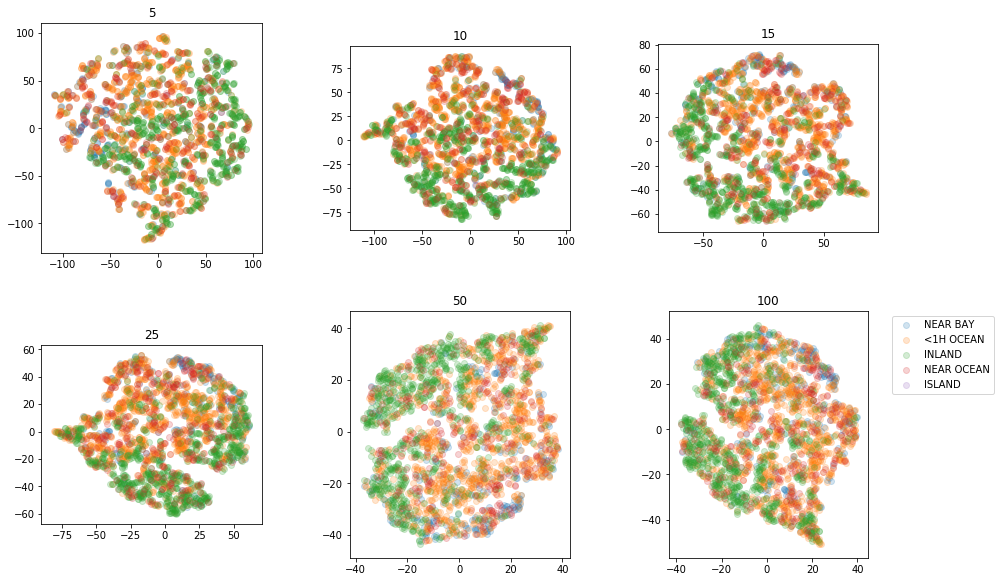

In [71]:
fig = plt.figure(figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.4)
index = 0
plot_index = 1
perplexities = [5, 10, 15, 25, 50, 100]

for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(2, 3, plot_index)
        p1,p2 = tsne_results[index][:,0], tsne_results[index][:,1]

        for lvl in housing['ocean_proximity'].unique().tolist():
            k = (X['ocean_proximity'] == lvl)
            ax.scatter(p1[k], p2[k], label=lvl, alpha=0.2, cmap='Set2')
            ax.set_aspect('equal')
            ax.set_title(perplexities[index])
        
        index += 1
        plot_index +=1
        
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
plt.show()

**Question 5.** Run PCA as in question 1. Let $X$ be the full feature matrix, of size $n\times K$, and let $\tilde{X}^L$ be the approximation to $X$ using only the first $L$ principal components, $L=0,\dots,K$. Plot a bar chart with $L$ on the $x$-axis, and the mean square error 
$$
\operatorname{MSE} = \frac{1}{n}\sum_{i=1}^n \sum_{k=1}^K(X_{i,k}-\tilde{X}^L_{i,j})^2
$$ on the $y$-axis.

Hint: [`plt.bar(x,y)`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.bar.html) plots a bar char.

**Question 6.** We'd like to decide how many components to use with PCA.
The number of components to use, call it $L$, is a hyperparameter, and the usual way to choose a hyperparameter is by cross validation.
But it takes some thinking to find a good way to run cross validation on an autoencoder...
Suppose we've implemented PCA as a pair of functions
* `enc(X,L)` which encodes a $n\times K$ dataset $X$ into a $n\times L$ matrix, keeping the first $L$ components for each record
* `dec(Λ)` which decodes a $n\times L$ set of components into a $n\times K$ reconstruction of the data

The naive approach to cross validation would be to train `enc,dec` on a training set of data, to set aside a test set `Xtest`, and to pick $L$ to make
the reconstruction `dec(enc(Xtest,L))` as close as possible to the original `Xtest`. But this is useless, because $L=K$ will always yield perfect reconstruction.

An alternative approach is to measure *denoising ability*. If we see this picture 

<div>
<img src="weasey6.jpg" style="height:8em"/>
</div>

we don't think "This is a weasel with no back legs", we think "This is a normal weasel and its back legs are occluded". In other words, from the occluded image, we can find the low-dimensional latent representation "this is a weasel", from which we can predict how the animal would look it it weren't occluded. This is called *denoising*.

Likewise, we can measure the performance of an autoencoder by the difference between `Xtest` and `dec(enc(n(Xtest),L))` where `n` is some function that adds noise.

Your task is to use cross-validation to pick the optimal number of components $L$ to use, as measured by denoising ability for the two types of noise below. Here is a code skeleton to
get you started.

```
def noisify_gaussian(x): 
    σ = np.std(x, axis=0)
    return np.random.normal(loc=x, scale=σ)

def noisify_mask(x):
    μ = np.mean(x, axis=0)
    n,K = x.shape
    k = np.random.choice(np.arange(K), size=n)
    y = np.copy(x)
    y[np.arange(n), k] = μ[k]
    return y

def train_model(X):
    ...
    def enc(Xnew, L):
        return ...
    def dec(Λ):
        return ...
    return enc,dec    

# Sanity check, on a single train/test split

df = housing.dropna(subset=features)
X = df[features].values
n,K = X.shape

i_train, i_test = next(kf.split(np.arange(n)))
Xtrain, Xtest = X[i_train], X[i_test]
enc,dec = train_model(Xtrain)

# We should get perfect reconstruction, if we use all K components
assert np.allclose(dec(enc(Xtest,K)), Xtest)
# Imperfect reconstruction, if we use fewer
assert not np.allclose(dec(enc(Xtest,K-1)), Xtest)

# Denoising, using 3 components
dec(enc(noisify_mask(Xtest),3))
```

**Question 7 (optional).** Use PCA on the the expanded set of features consisting of `features` as specified in the assignment, plus `ocean_proximity` encoded numerically. 
Explain how you have chosen to encode it, and how you will scale the columns. Apply PCA, and plot the first two components. Is the output more useful than that of question 1?